# Intro

`ms_blocking` is a simple package built on `pandas`, `scipy`, and `networkx` that makes it easy to efficiently regroup rows of a pandas DataFrame based on equality of overlap between the elements of a column.

# Examples

## Imports

In [1]:
import ms_blocking.ms_blocking as msb

## Sample data

We first import some example data. The `ms_blocking.datasets` module contains an example DataFrame you can use to explore the various functionalities of the package.

In [2]:
from ms_blocking.datasets import get_users

df = get_users()
df

,id,Name,City,Age,websites
0,0,Jean d'Aux,Lille,26,"['jeandaux.fr', 'lillefans.fr']"
1,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu..."
2,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59']
3,3,Paul Delarue,Roubaix,32,['roubaixlove.fr']
4,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr']
5,5,pierre dusquesnes,Phalempin,24,[]
6,6,Jean-Michel Python,Douai,49,"['lensfans.fr', 'pythonensamusant.fr']"
7,7,Gédéon Glincarné,Paris,53,['lorem.fr']
8,8,Sophie Delarue,Roubaix,33,[]
9,9,Jeanne Verbrugge,Valenciennes,41,['somewebsite.com/users/jajanne59']


## Basic example: Attribute equivalence

For starters, let's see how we can regroup our different users by city.

We simply define a `Blocker` the following way:

In [3]:
city_blocker = msb.AttributeEquivalenceBlocker(["City"])

Note that the blocker has not computed anything yet (blocking is *lazy* in computing terms). It simply stored the instruction that its purpose is to block on some 'City' attribute, regardless of the dataset(s) it will be used on.

And then, we use the following syntax to block on the DataFrame:

In [4]:
links = city_blocker.block(df)

Processing AttributeEquivalenceBlocker(['City'], [])


Since this links are nothing more than a set of pairs of id's, what's stored in memory is simply a graph of related id's:

In [5]:
links

{frozenset({3, 8}),
 frozenset({1, 4}),
 frozenset({8, 11}),
 frozenset({3, 11}),
 frozenset({2, 5}),
 frozenset({10, 13})}

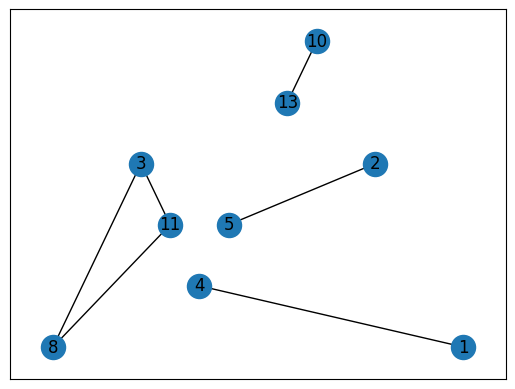

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
g.add_edges_from(links)
nx.draw_networkx(g, pos=nx.planar_layout(g))

Finally, we can 'apply' these links to the original DataFrame to actually see how the rows are grouped together:

In [7]:
msb.add_blocks_to_dataset(df, links)

,id,Name,City,Age,websites,block
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",0
1,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0
2,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59'],1
3,5,pierre dusquesnes,Phalempin,24,[],1
4,3,Paul Delarue,Roubaix,32,['roubaixlove.fr'],2
5,8,Sophie Delarue,Roubaix,33,[],2
6,11,sophie_delarue,Roubaix,33,[],2
7,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",3
8,13,Benoît Benoît,Lens,15,['lensfans.fr'],3


Since pairs can be seen as links between nodes in an non-oriented graph, transforming a set of pairs into a set of group is done by solving the classic connected coomponents graph problem:

In [8]:
import ms_blocking.utils as utils

utils.solve_connected_components_from_coords(links)

array([-1,  0,  1,  2,  0,  1, -1, -1,  2, -1,  3,  2, -1,  3])

The above output shows that user #1 is in its own cluster, #1 and #4 belong to the same block, #2 and #5 belong to the same block, and so on.

## Overlap

If a column contains list-like elements and we want to group rows based on overlap between said lists, we can use an `OverlapBlocker`:

In [9]:
websites_blocker = msb.OverlapBlocker(["websites"])
links = websites_blocker.block(df)
msb.add_blocks_to_dataset(df, links)

Processing OverlapBlocker(['websites'], 1)


,id,Name,City,Age,websites,block
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",0
1,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0
2,6,Jean-Michel Python,Douai,49,"['lensfans.fr', 'pythonensamusant.fr']",0
3,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",0
4,13,Benoît Benoît,Lens,15,['lensfans.fr'],0


### Prevent merging of blocks

/!\ Notice that users #4 and #6 are still grouped together even though they have no websites in common. This is due to the fact that since they both share a website with user #1, they end up in the same block.

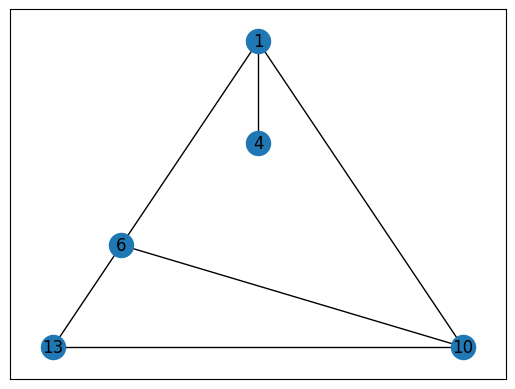

In [10]:
g = nx.Graph()
g.add_edges_from(links)
nx.draw_networkx(g, pos=nx.planar_layout(g))

If you prefer the opposite behavior, simply pass `merge_blocks=False` when calling `add_blocks_to_dataset`:

In [11]:
msb.add_blocks_to_dataset(df, links, merge_blocks=False)

,id,Name,City,Age,websites,block
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",0
1,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0
2,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",1
3,6,Jean-Michel Python,Douai,49,"['lensfans.fr', 'pythonensamusant.fr']",1
4,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",1
5,6,Jean-Michel Python,Douai,49,"['lensfans.fr', 'pythonensamusant.fr']",2
6,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",2
7,13,Benoît Benoît,Lens,15,['lensfans.fr'],2


Instead of solving the connected components graph problem, the above behavior is obtained by solving the cliques graph problem instead.

### Different overlap

You may specify a greater overlap.

For instance, here we only regroup users that share >=2 websites.

In [12]:
websites_blocker_2 = msb.OverlapBlocker(["websites"], overlap=2)
links = websites_blocker_2.block(df)
msb.add_blocks_to_dataset(df, links)

Processing OverlapBlocker(['websites'], 2)


,id,Name,City,Age,websites,block
0,6,Jean-Michel Python,Douai,49,"['lensfans.fr', 'pythonensamusant.fr']",0
1,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",0


## Multiple-column blocking

When instantiating the blocker, you may specify two columns (or more), in which case rows will only be regrouped if they share both columns.

In [13]:
city_and_age_blocker = msb.AttributeEquivalenceBlocker(["City", "Age"])
links = city_and_age_blocker.block(df)
msb.add_blocks_to_dataset(df, links)

Processing AttributeEquivalenceBlocker(['Age', 'City'], [])


,id,Name,City,Age,websites,block
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",0
1,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0
2,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59'],1
3,5,pierre dusquesnes,Phalempin,24,[],1
4,8,Sophie Delarue,Roubaix,33,[],2
5,11,sophie_delarue,Roubaix,33,[],2


### Normalization

Note that by default, blocking will ignore case and special characters:

In [14]:
name_blocker = msb.AttributeEquivalenceBlocker(["Name"])
links = name_blocker.block(df)
msb.add_blocks_to_dataset(df, links)

Processing AttributeEquivalenceBlocker(['Name'], [])


,id,Name,City,Age,websites,block
0,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59'],0
1,5,pierre dusquesnes,Phalempin,24,[],0


This behavior can be prevented using `normalize_strings=False` when instantiating a blocker:

In [15]:
normalized_name_blocker = msb.AttributeEquivalenceBlocker(
    ["Name"], normalize_strings=False
)
links = normalized_name_blocker.block(df)
msb.add_blocks_to_dataset(df, links)

Processing AttributeEquivalenceBlocker(['Name'], [])


,id,Name,City,Age,websites,block


# Pipelining

The point of *lazy* blocking is to enable the writing of blocking *pipelines*, where complex `Blockers` are defined as the union or interesection of simple `Blockers` using intuitive algebraic notation.

### Intersection

You may define a blocker as the intersection of two blockers, in which case the output will reflect *both* blocking conditions:

In [16]:
links_city = city_blocker.block(df)
links_websites = websites_blocker.block(df)

Processing AttributeEquivalenceBlocker(['City'], [])
Processing OverlapBlocker(['websites'], 1)


In [17]:
links = (city_blocker & websites_blocker).block(df)
msb.add_blocks_to_dataset(df, links)

Processing MixedBlocker(['City'], ['websites'], 1)


,id,Name,City,Age,websites,block
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",0
1,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0
2,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",1
3,13,Benoît Benoît,Lens,15,['lensfans.fr'],1


### Union

Likewise, you may define a blocker as the union of two blockers, in which case the output will reflect *either* blocking conditions:

In [18]:
links = (city_blocker | websites_blocker).block(df)
msb.add_blocks_to_dataset(df, links)

Processing AttributeEquivalenceBlocker(['City'], [])
Processing OverlapBlocker(['websites'], 1)


,id,Name,City,Age,websites,block
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",0
1,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0
2,6,Jean-Michel Python,Douai,49,"['lensfans.fr', 'pythonensamusant.fr']",0
3,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",0
4,13,Benoît Benoît,Lens,15,['lensfans.fr'],0
5,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59'],1
6,5,pierre dusquesnes,Phalempin,24,[],1
7,3,Paul Delarue,Roubaix,32,['roubaixlove.fr'],2
8,8,Sophie Delarue,Roubaix,33,[],2
9,11,sophie_delarue,Roubaix,33,[],2


## Pipelining

`ms_blocking` makes it trivial to convert some 'if''s- and 'else''s-based rules into blocking rules.

For instance, assume we want to regroup rows based on the following natural-language rule:
- IF two users live in the same city THEN regroup them if and only if they have the same age
- ELSE IF two users share the same name THEN regroup them if and only if they share at least one website

The conversion to our syntax is direct:

First define each rule as a simple `Blocker`:

In [19]:
city_blocker = msb.AttributeEquivalenceBlocker(["City"])
age_blocker = msb.AttributeEquivalenceBlocker(["Age"])
name_blocker = msb.AttributeEquivalenceBlocker(["Name"])
websites_blocker = msb.OverlapBlocker(["websites"])

Then turn 'if''s and 'else''s into unions and 'then''s into intersections:

In [20]:
final_blocker = (city_blocker & age_blocker) | (name_blocker & websites_blocker)

And block:

In [21]:
links = final_blocker.block(df)
msb.add_blocks_to_dataset(df, links)

Processing AttributeEquivalenceBlocker(['Age', 'City'], [])
Processing MixedBlocker(['Name'], ['websites'], 1)


,id,Name,City,Age,websites,block
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",0
1,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0
2,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59'],1
3,5,pierre dusquesnes,Phalempin,24,[],1
4,8,Sophie Delarue,Roubaix,33,[],2
5,11,sophie_delarue,Roubaix,33,[],2


# Other

In [22]:
city_blocker = msb.AttributeEquivalenceBlocker(["City"])
links = city_blocker.block(df)

Processing AttributeEquivalenceBlocker(['City'], [])


## Sort

By default, when adding blocks to a DataFrame, the output will by sorted by block.

This behavior can be prevented by passing sort=False to add_blocks_to_dataset.

In [23]:
msb.add_blocks_to_dataset(df, links, sort=False)

,id,Name,City,Age,websites,block
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",0
1,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59'],1
2,3,Paul Delarue,Roubaix,32,['roubaixlove.fr'],2
3,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0
4,5,pierre dusquesnes,Phalempin,24,[],1
5,8,Sophie Delarue,Roubaix,33,[],2
6,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",3
7,11,sophie_delarue,Roubaix,33,[],2
8,13,Benoît Benoît,Lens,15,['lensfans.fr'],3


## Ungrouped rows

By default, when adding blocks to a DataFrame, the output will only contain rows that share a block with at least one other row.

This behavior can be prevented by passing `keep_ungrouped_rows=True` to `add_blocks_to_dataset`. Ungrouped rows will each belong to their own block.

In [24]:
msb.add_blocks_to_dataset(df, links, keep_ungrouped_rows=True)

,id,Name,City,Age,websites,block
0,0,Jean d'Aux,Lille,26,"['jeandaux.fr', 'lillefans.fr']",0
1,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",1
2,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],1
3,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59'],2
4,5,pierre dusquesnes,Phalempin,24,[],2
5,3,Paul Delarue,Roubaix,32,['roubaixlove.fr'],3
6,8,Sophie Delarue,Roubaix,33,[],3
7,11,sophie_delarue,Roubaix,33,[],3
8,6,Jean-Michel Python,Douai,49,"['lensfans.fr', 'pythonensamusant.fr']",4
9,7,Gédéon Glincarné,Paris,53,['lorem.fr'],5


## Motives

You might be interested in keeping track of *why* some rows were put in the same group, especially when you have data with many attributes. Juste pass `motives=True` to the `block` method.

In [25]:
city_blocker = msb.AttributeEquivalenceBlocker(["City"])
links = city_blocker.block(df, motives=True)
links

Processing AttributeEquivalenceBlocker(['City'], [])


{frozenset({3, 8}): {"Same ['City']"},
 frozenset({1, 4}): {"Same ['City']"},
 frozenset({8, 11}): {"Same ['City']"},
 frozenset({3, 11}): {"Same ['City']"},
 frozenset({2, 5}): {"Same ['City']"},
 frozenset({10, 13}): {"Same ['City']"}}

Of course, this will induce some overhead.

Similarly, you may add `motives=True` to the `msb.add_blocks_to_dataset` function to see said motives:

In [26]:
msb.add_blocks_to_dataset(df, links, motives=True)

,id,Name,City,Age,websites,block,motive
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",0,(Same ['City'])
1,4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0,(Same ['City'])
2,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59'],1,(Same ['City'])
3,5,pierre dusquesnes,Phalempin,24,[],1,(Same ['City'])
4,3,Paul Delarue,Roubaix,32,['roubaixlove.fr'],2,(Same ['City'])
5,8,Sophie Delarue,Roubaix,33,[],2,(Same ['City'])
6,11,sophie_delarue,Roubaix,33,[],2,(Same ['City'])
7,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",3,(Same ['City'])
8,13,Benoît Benoît,Lens,15,['lensfans.fr'],3,(Same ['City'])


... Though since motives make more sense when considering pairs of rows instead of full blocks, the above visualization is not that interesting...

... Which is the reason you can pass `show_as_pairs=True` to `msb.add_blocks_to_dataset` to see the output has a list of pairs:

In [27]:
msb.add_blocks_to_dataset(df, links, motives=True, show_as_pairs=True)

,id_l,Name_l,City_l,Age_l,websites_l,id_r,Name_r,City_r,Age_r,websites_r,block,motive
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0,(Same ['City'])
1,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59'],5,pierre dusquesnes,Phalempin,24,[],1,(Same ['City'])
2,3,Paul Delarue,Roubaix,32,['roubaixlove.fr'],11,sophie_delarue,Roubaix,33,[],2,(Same ['City'])
3,8,Sophie Delarue,Roubaix,33,[],3,Paul Delarue,Roubaix,32,['roubaixlove.fr'],2,(Same ['City'])
4,8,Sophie Delarue,Roubaix,33,[],11,sophie_delarue,Roubaix,33,[],2,(Same ['City'])
5,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",13,Benoît Benoît,Lens,15,['lensfans.fr'],3,(Same ['City'])


If our dataset had many columns, the above output would be too large to easily be read, so we added the `output_columns` option:

In [28]:
msb.add_blocks_to_dataset(
    df, links, motives=True, show_as_pairs=True, output_columns=["id", "Name"]
)

,id_l,Name_l,id_r,Name_r,block,motive
0,1,Jacques Dupond,4,Jacques Dupont,0,(Same ['City'])
1,2,Pierre Dusquesnes,5,pierre dusquesnes,1,(Same ['City'])
2,3,Paul Delarue,11,sophie_delarue,2,(Same ['City'])
3,8,Sophie Delarue,3,Paul Delarue,2,(Same ['City'])
4,8,Sophie Delarue,11,sophie_delarue,2,(Same ['City'])
5,10,Caroline Dufour,13,Benoît Benoît,3,(Same ['City'])


Motives are dynamic:

In [29]:
msb.generate_blocking_report(df, links)

,id_l,Name_l,City_l,Age_l,websites_l,id_r,Name_r,City_r,Age_r,websites_r,block,motive
0,1,Jacques Dupond,Villeneuve d'Ascq,37,"['somewebsite.com/users/jacquesdupond', 'jacqu...",4,Jacques Dupont,Villeneuve d'Ascq,37,['jacquesdupond.fr'],0,(Same ['City'])
1,2,Pierre Dusquesnes,Phalempin,24,['somewebsite.com/users/rpz59'],5,pierre dusquesnes,Phalempin,24,[],1,(Same ['City'])
2,3,Paul Delarue,Roubaix,32,['roubaixlove.fr'],11,sophie_delarue,Roubaix,33,[],2,(Same ['City'])
3,8,Sophie Delarue,Roubaix,33,[],3,Paul Delarue,Roubaix,32,['roubaixlove.fr'],2,(Same ['City'])
4,8,Sophie Delarue,Roubaix,33,[],11,sophie_delarue,Roubaix,33,[],2,(Same ['City'])
5,10,Caroline Dufour,Lens,45,"['pythonensamusant.fr', 'lensfans.fr']",13,Benoît Benoît,Lens,15,['lensfans.fr'],3,(Same ['City'])


In [30]:
city_blocker = msb.AttributeEquivalenceBlocker(["City"])
age_blocker = msb.AttributeEquivalenceBlocker(["Age"])
websites_blocker = msb.OverlapBlocker(["websites"])
final_blocker = (city_blocker & age_blocker) | websites_blocker
links = final_blocker.block(df, motives=True)
msb.add_blocks_to_dataset(
    df,
    links,
    motives=True,
    show_as_pairs=True,
    output_columns=["id", "Name"],
    merge_blocks=False,
)

Processing AttributeEquivalenceBlocker(['Age', 'City'], [])
Processing OverlapBlocker(['websites'], 1)


,id_l,Name_l,id_r,Name_r,block,motive
0,1,Jacques Dupond,4,Jacques Dupont,0,"(>= 1 overlap in ['websites'], Same ['Age', 'C..."
1,1,Jacques Dupond,6,Jean-Michel Python,0,"(>= 1 overlap in ['websites'], Same ['Age', 'C..."
2,1,Jacques Dupond,10,Caroline Dufour,0,"(>= 1 overlap in ['websites'], Same ['Age', 'C..."
3,1,Jacques Dupond,4,Jacques Dupont,1,"(>= 1 overlap in ['websites'], Same ['Age', 'C..."
4,1,Jacques Dupond,6,Jean-Michel Python,1,"(>= 1 overlap in ['websites'], Same ['Age', 'C..."
5,1,Jacques Dupond,10,Caroline Dufour,1,"(>= 1 overlap in ['websites'], Same ['Age', 'C..."
6,10,Caroline Dufour,6,Jean-Michel Python,1,(>= 1 overlap in ['websites'])
7,10,Caroline Dufour,13,Benoît Benoît,1,(>= 1 overlap in ['websites'])
8,2,Pierre Dusquesnes,5,pierre dusquesnes,2,"(Same ['Age', 'City'])"
9,8,Sophie Delarue,11,sophie_delarue,3,"(Same ['Age', 'City'])"
